## Import necessary libraries


In [2]:
# Set the working directory
sys.path.append(os.getcwd() + os.sep + ".." + os.sep + "..")

# Import the necessary libraries
import pycaret.classification as pc
import pandas as pd
import os
import sys
import src.scripts.mapping_answers_dict as map_dict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from math import sqrt


## Dataset loading

In [4]:
# Load the merged dataset
dataset = pd.read_csv("../../data/processed/GYTS_dataset.csv")

# Convert categorical columns
categorical_columns = ["State", "Gender", "Age", "SmokingFriends", "SeenSmokerInPublicPlace",
                       "SeenSmokerInEnclosedPlace", "SeenSmokerInHome", "AttractiveSmoker",
                       "HardQuitSmoke", "SmokerConfidentInCelebrations", "SchoolWarnings",
                       "SeenHealthWarnings", "AntiTobaccoInEvents", "HarmfulPassiveSmoke"]
dataset[categorical_columns] = dataset[categorical_columns].astype('category')

# Convert boolean columns
boolean_columns = ["Smoke", "SeenSmokerInSchool", "ParentWarnings", "AntiTobaccoInMedia",
                   "BanTobaccoOutdoors", "SmokingFather", "SmokingMother", "WorkingFather",
                   "WorkingMother"]
dataset[boolean_columns] = dataset[boolean_columns].astype('bool')

# Comparing models

In [7]:
setup = pc.setup(data=dataset,
                 target='Smoke',
                 index=False,
                 train_size=0.8,
                 session_id=42,
                 ordinal_features={
                     "SmokingFriends": map_dict.OR46_dict.values(),
                     "SeenSmokerInPublicPlace": map_dict.CR21_dict.values(),
                     "SeenSmokerInEnclosedPlace": map_dict.CR20_dict.values(),
                     "SeenSmokerInHome": map_dict.CR19_dict.values(),
                     "HarmfulPassiveSmoke": map_dict.CR23_dict.values(),
                     "HardQuitSmoke": map_dict.CR41_dict.values(),
                 },
                 transformation=True,
                 max_encoding_ohe=0,
                 n_jobs=10
                 )

,Description,Value
0,Session id,42
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(20731, 23)"
4,Transformed data shape,"(20731, 23)"
5,Transformed train set shape,"(16584, 23)"
6,Transformed test set shape,"(4147, 23)"
7,Ordinal features,6
8,Categorical features,14
9,Preprocess,True


# Compute the class weights

In [8]:

classes = dataset['Smoke'].unique()

class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=pc.get_config("y_train_transformed"))
sqrt_weights = [sqrt(weight) for weight in class_weights]

class_weights = dict(zip(classes, class_weights))
sqrt_weights = dict(zip(classes, sqrt_weights))

print(class_weights)
print(sqrt_weights)


{True: 3.0440528634361232, False: 0.5982683982683983}
{True: 1.7447214286057597, False: 0.7734781175110246}


Find the best model within the class-weight supporting ones

In [12]:
#all_models = [ 'lr', 'knn', 'nb', 'dt', 'svm', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost'] #'rbfsvm', 'gpc', 'mlp'

# Models that support class weights
threshold_optimized_model =[ 'lr', 'dt', 'svm' , 'ridge', 'rf', 'et', 'lightgbm'] # 'rbfsvm'
models = {}
predicts = pd.DataFrame()

for model_name in threshold_optimized_model:
    try:
        model = pc.create_model(model_name, verbose=False, class_weight=sqrt_weights)
        models[model_name] = model
        pc.predict_model(model)
        predict = pc.pull()
        predicts = pd.concat([predicts, predict])
    except Exception as e:
        print(e)
        print(f"Model {model} cannot have weights")

# Sort the models by MCC
predicts = predicts.sort_values('MCC', ascending=False)
predicts


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8457,0.8625,0.5888,0.5269,0.5562,0.4631,0.4642


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8182,0.6737,0.4581,0.4476,0.4528,0.3438,0.3439


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8488,0.7078,0.4978,0.5433,0.5195,0.4300,0.4306


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8478,0.7414,0.5830,0.5336,0.5572,0.4655,0.4662


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8835,0.8893,0.3847,0.8037,0.5204,0.4633,0.5042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8821,0.8827,0.3759,0.8000,0.5115,0.4542,0.4963


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8763,0.8931,0.6446,0.6183,0.6312,0.5569,0.5571


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8763,0.8931,0.6446,0.6183,0.6312,0.5569,0.5571
0,Random Forest Classifier,0.8835,0.8893,0.3847,0.8037,0.5204,0.4633,0.5042
0,Extra Trees Classifier,0.8821,0.8827,0.3759,0.8000,0.5115,0.4542,0.4963
0,Ridge Classifier,0.8478,0.7414,0.5830,0.5336,0.5572,0.4655,0.4662
0,Logistic Regression,0.8457,0.8625,0.5888,0.5269,0.5562,0.4631,0.4642
0,SVM - Linear Kernel,0.8488,0.7078,0.4978,0.5433,0.5195,0.4300,0.4306
0,Decision Tree Classifier,0.8182,0.6737,0.4581,0.4476,0.4528,0.3438,0.3439


Choosing best model


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8656,0.6162,0.4982,0.6126,0.5495,0.4715,0.4750
1,0.8740,0.6276,0.5275,0.6429,0.5795,0.5062,0.5097
2,0.8692,0.6295,0.5568,0.6129,0.5835,0.5061,0.5069
3,0.8571,0.6068,0.5311,0.5709,0.5503,0.4655,0.4659
4,0.8673,0.6553,0.4779,0.6250,0.5417,0.4657,0.4714
5,0.8733,0.6389,0.5331,0.6360,0.5800,0.5061,0.5088
6,0.8788,0.6199,0.5441,0.6578,0.5956,0.5250,0.5283
7,0.8661,0.6488,0.5404,0.6025,0.5698,0.4908,0.4918
8,0.8613,0.6670,0.5074,0.5897,0.5455,0.4641,0.4660


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8835,0.8893,0.3847,0.8037,0.5204,0.4633,0.5042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8840,0.8941,0.5859,0.6672,0.6239,0.5557,0.5573


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8662,0.5335,0.5421,0.6041,0.5714,0.4924,0.4934
1,0.8626,0.5966,0.5348,0.5911,0.5615,0.4803,0.4811
2,0.8704,0.6407,0.6044,0.6066,0.6055,0.5280,0.5280
3,0.8547,0.5704,0.5568,0.5588,0.5578,0.4709,0.4709
4,0.8643,0.6265,0.5184,0.6000,0.5562,0.4766,0.4784
5,0.8613,0.5876,0.5515,0.5814,0.5660,0.4836,0.4838
6,0.8727,0.5659,0.5846,0.6187,0.6011,0.5255,0.5258
7,0.8637,0.6534,0.5846,0.5846,0.5846,0.5030,0.5030
8,0.8571,0.5931,0.5478,0.5665,0.5570,0.4718,0.4719


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8763,0.8931,0.6446,0.6183,0.6312,0.5569,0.5571


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8816,0.8960,0.6256,0.6435,0.6344,0.5638,0.5639


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8517,0.5824,0.5678,0.5477,0.5576,0.4685,0.4686
1,0.8596,0.5795,0.5824,0.5719,0.5771,0.4929,0.4930
2,0.8656,0.6153,0.6300,0.5850,0.6067,0.5258,0.5263
3,0.8475,0.5311,0.5788,0.5338,0.5554,0.4635,0.4641
4,0.8631,0.6270,0.5625,0.5862,0.5741,0.4926,0.4927
5,0.8540,0.5673,0.5699,0.5536,0.5616,0.4741,0.4741
6,0.8667,0.6191,0.6140,0.5901,0.6018,0.5218,0.5219
7,0.8613,0.6688,0.6250,0.5705,0.5965,0.5129,0.5137
8,0.8492,0.6408,0.5588,0.5390,0.5487,0.4583,0.4584


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8765,0.8963,0.6520,0.6175,0.6343,0.5601,0.5604


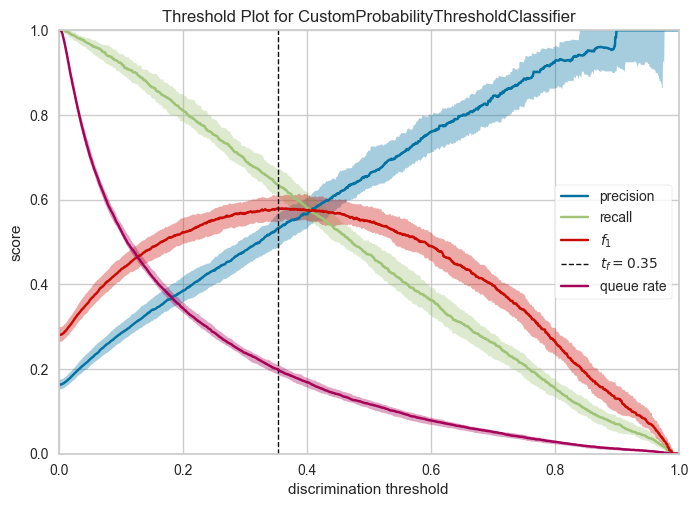

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [13]:

# model = best
rf_model = models['rf']
rf_ensemble_model = pc.ensemble_model(rf_model, method='Bagging', optimize='MCC', probability_threshold=0.35)

pc.predict_model(rf_model)
pc.predict_model(rf_ensemble_model)

lgbm_model = models['lightgbm']
lgbm_ensemble_model = pc.ensemble_model(lgbm_model, method='Bagging', optimize='MCC')

pc.predict_model(lgbm_model)
pc.predict_model(lgbm_ensemble_model)

blended_model = pc.blend_models(estimator_list=[rf_model, lgbm_model], optimize='MCC', probability_threshold=0.4) 
pc.predict_model(blended_model)

pc.plot_model(blended_model, plot='threshold')
pc.evaluate_model(blended_model)

In [16]:
# pc.evaluate_model(ensemble_model)


pc.dashboard(blended_model)
# print(tuned_weighted_model)

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/4147 [00:00<?, ?it/s]

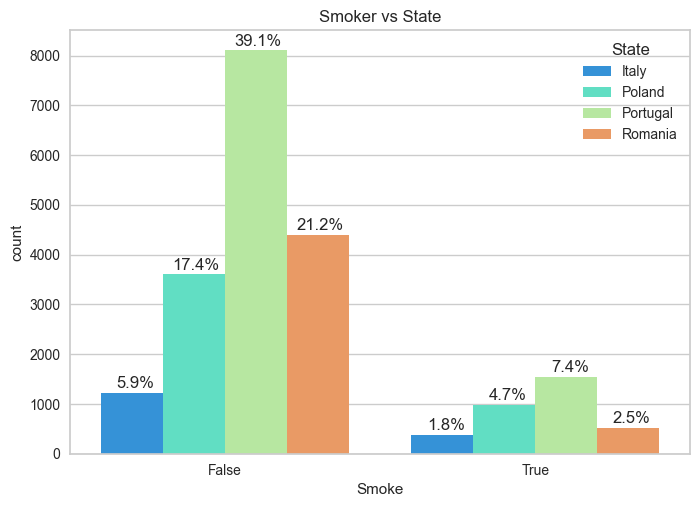

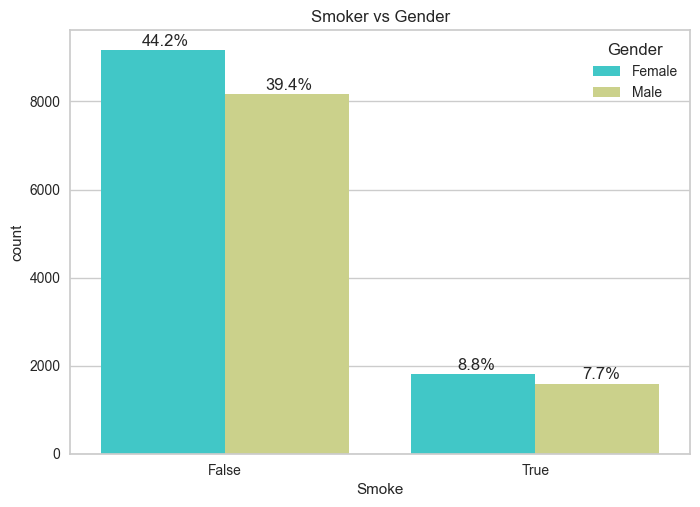

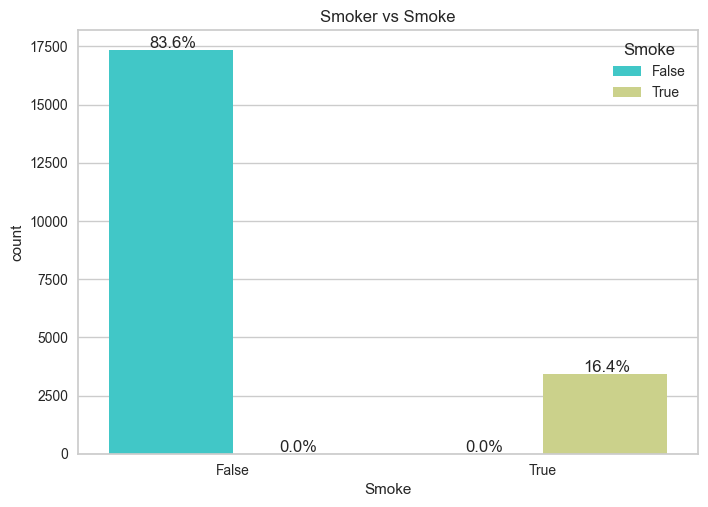

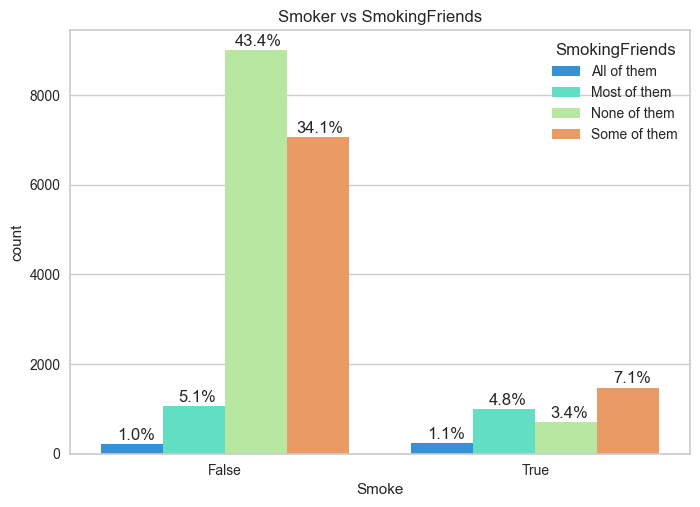

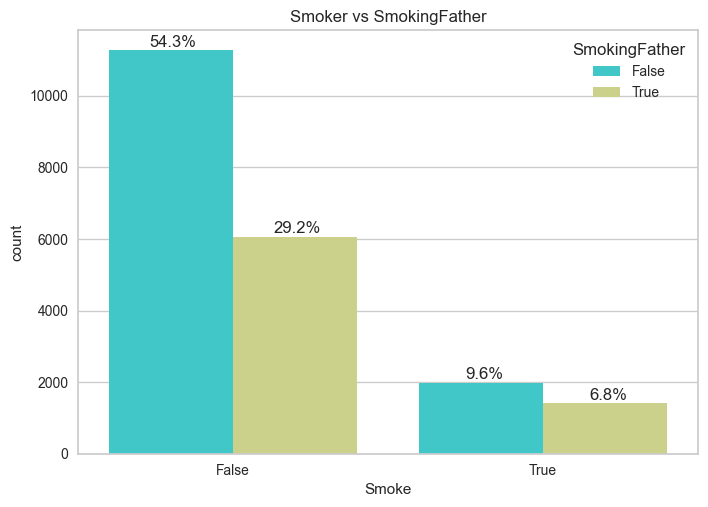

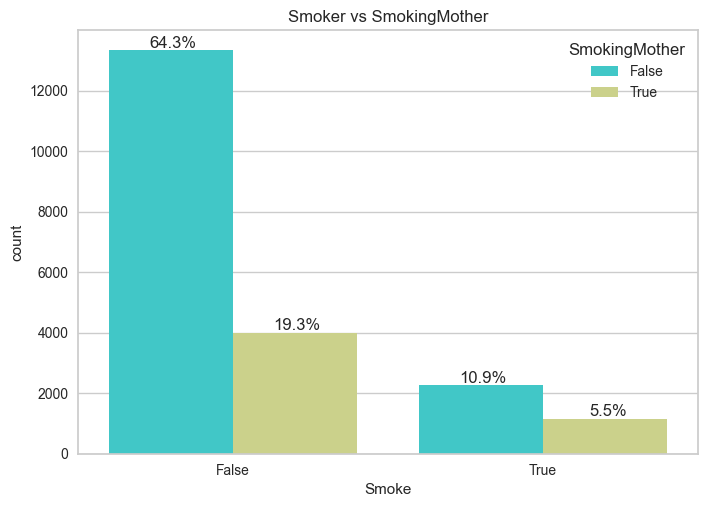

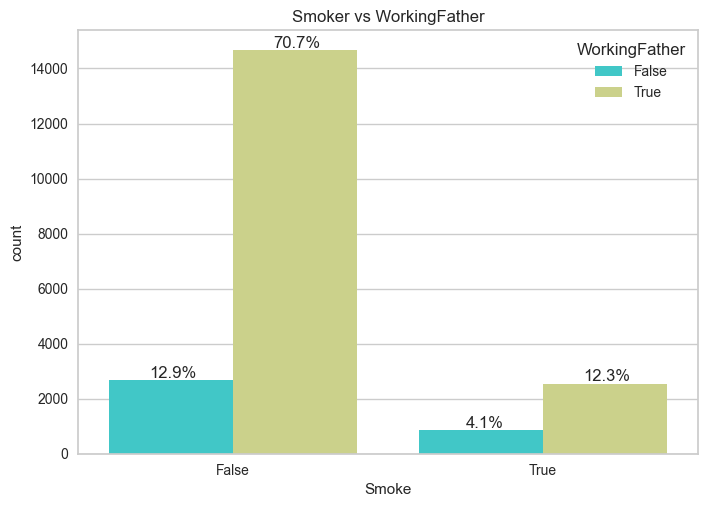

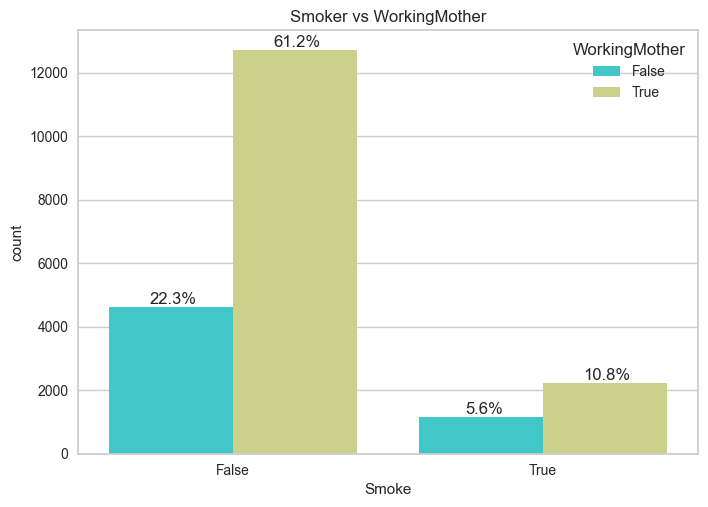

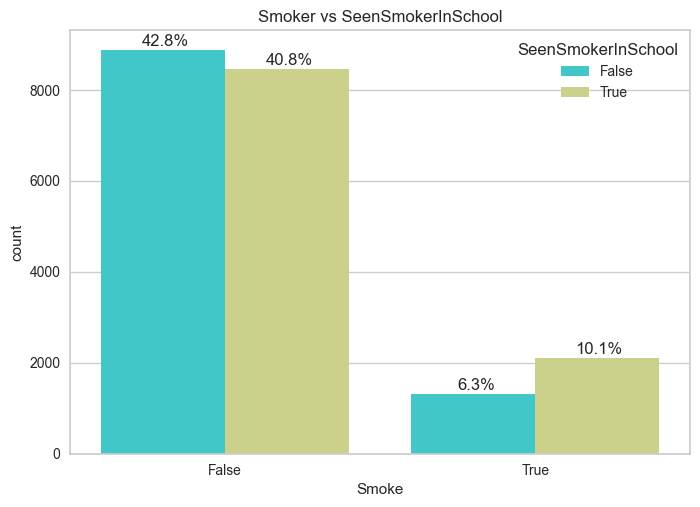

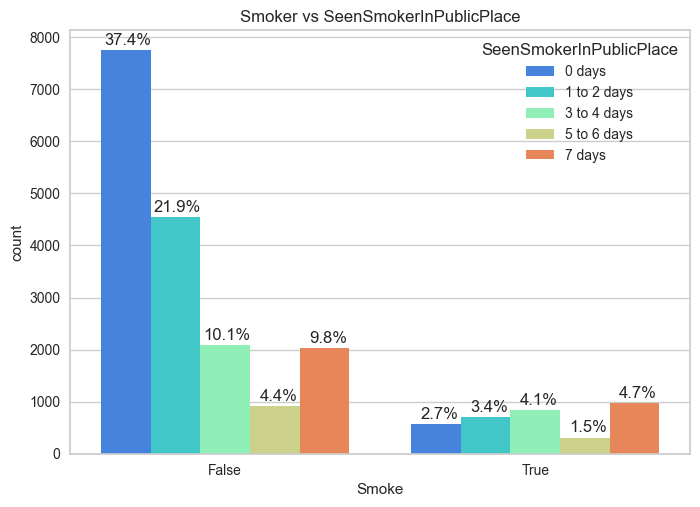

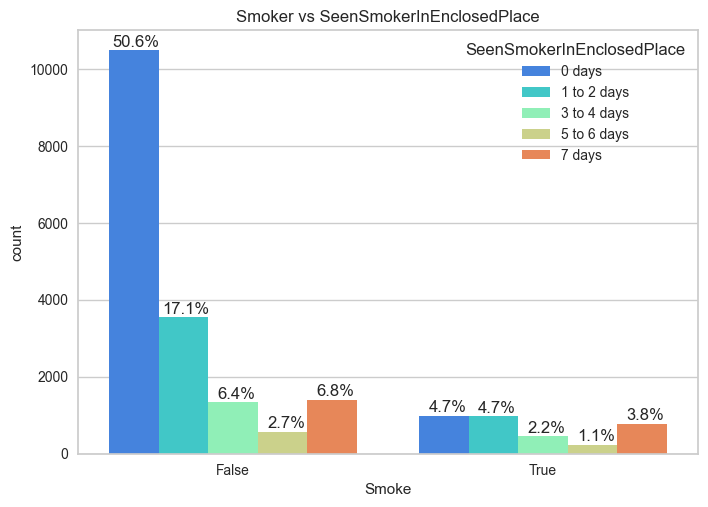

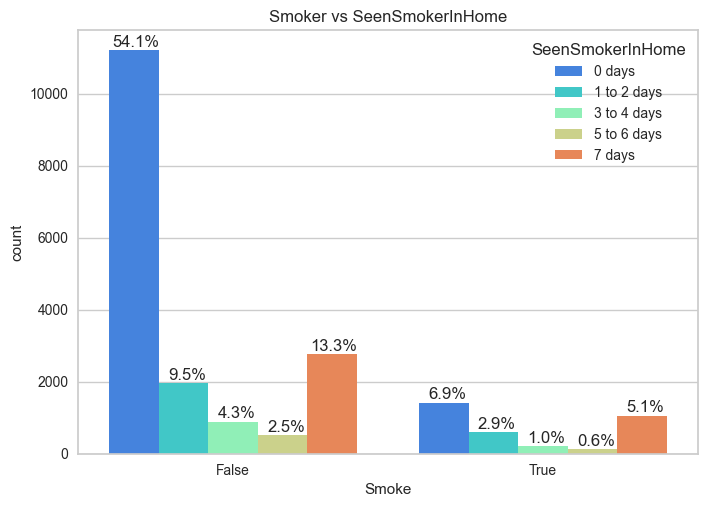

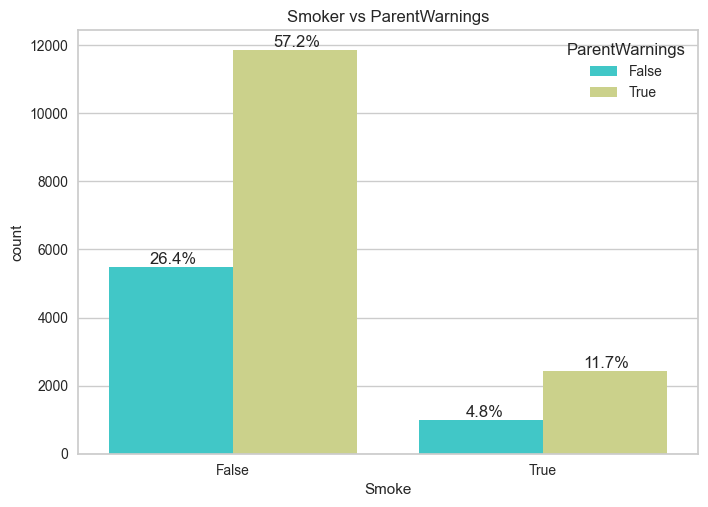

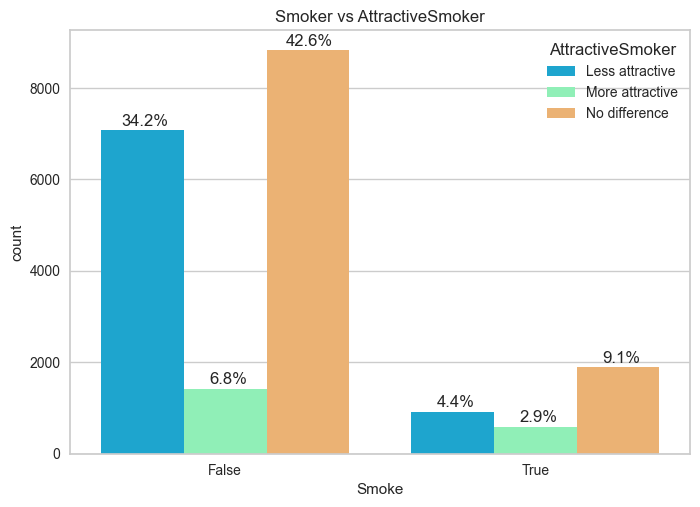

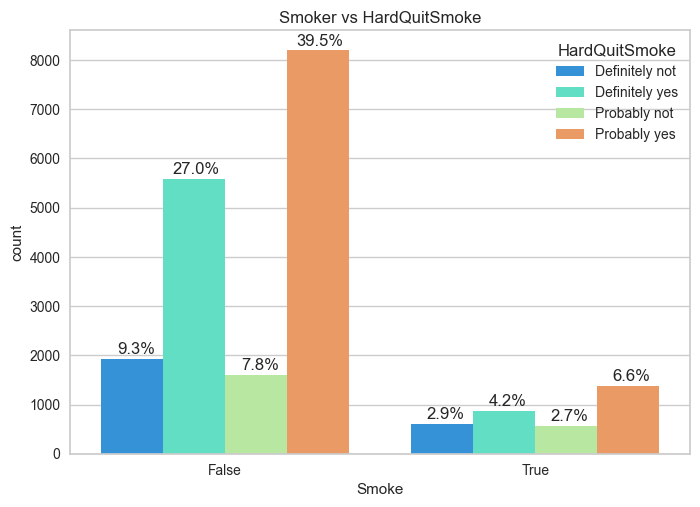

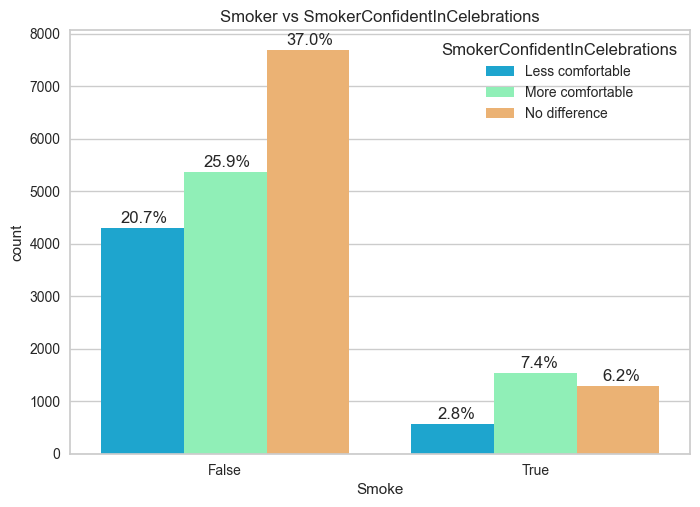

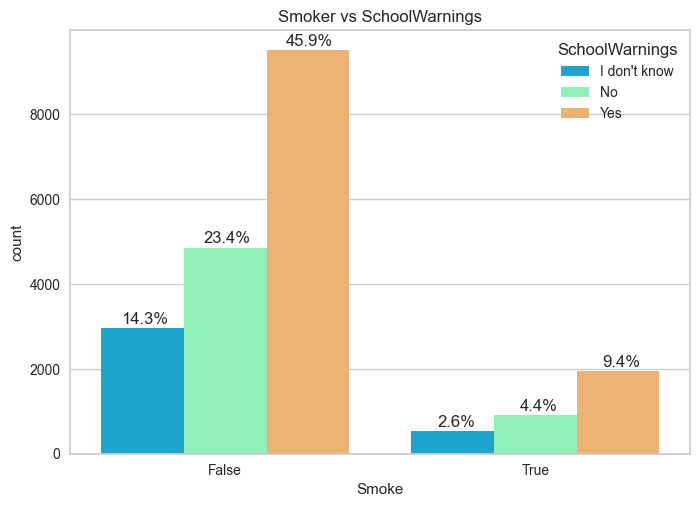

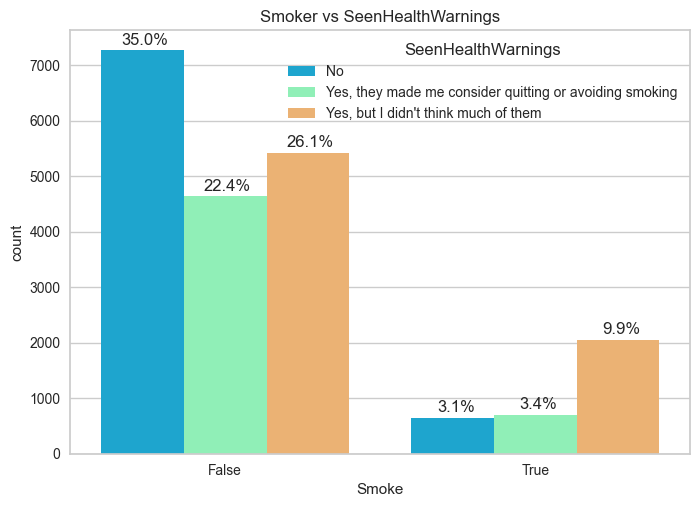

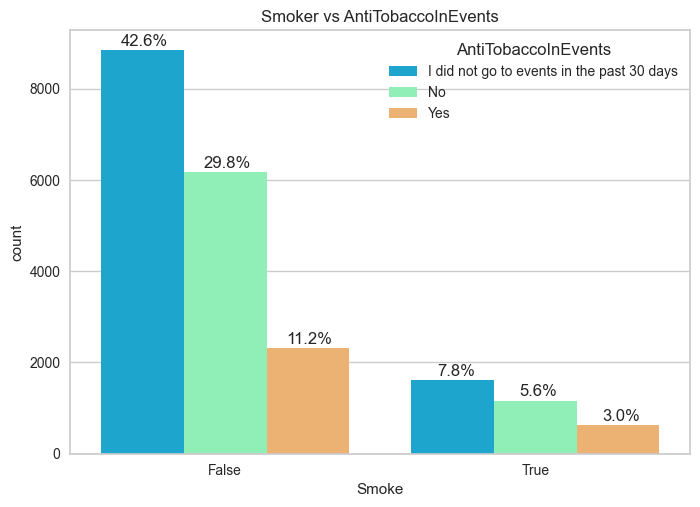

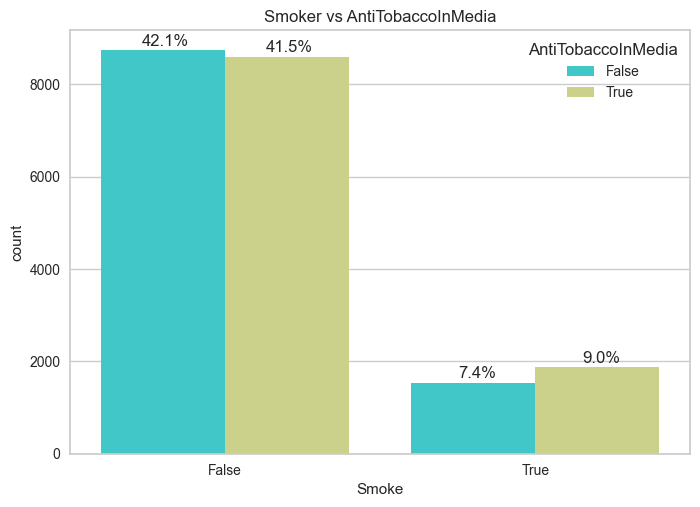

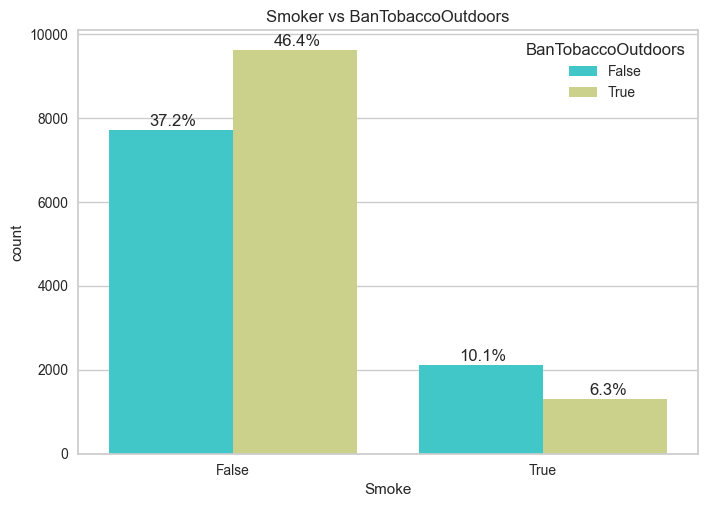

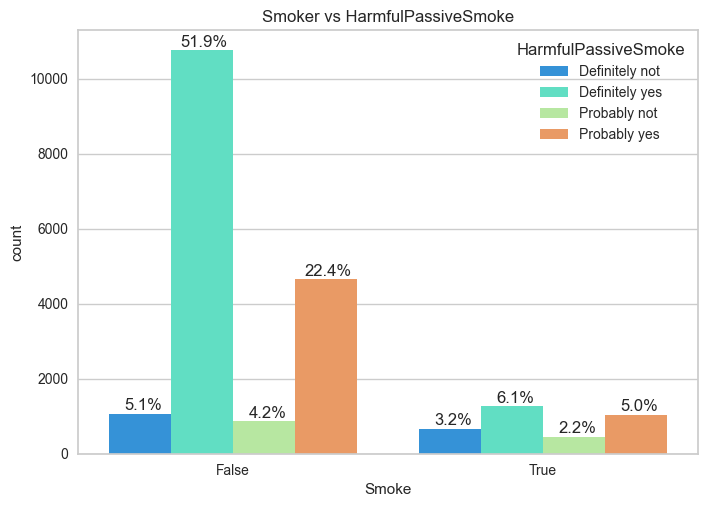

In [15]:
### Data analysis (Move to data_analysis.ipynb)

list_of_columns = ["State", "Gender", "Smoke", "SmokingFriends", 'SmokingFather', 'SmokingMother', 'WorkingFather', 'WorkingMother',
                       "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
                       "SeenSmokerInHome", "ParentWarnings", "AttractiveSmoker", "HardQuitSmoke",
                       "SmokerConfidentInCelebrations", "SchoolWarnings", "SeenHealthWarnings",
                       "AntiTobaccoInEvents", "AntiTobaccoInMedia", "BanTobaccoOutdoors",
                       "HarmfulPassiveSmoke"
                    ]

def bar_perc(plot, dataframe, feature):
    total = len(feature) # length of the column
    total_smokers = len(dataframe[dataframe['Smoke'] == True]) # length of the smokers
    total_non_smokers = len(dataframe[dataframe['Smoke'] == False]) # length of the non-smokers
  
    for i, p in enumerate(plot.patches):
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
     
        x = p.get_x() + p.get_width() / 2 - (0.05 if (100 * p.get_height()/total) < 10 else 0.07) # width of the plot
        y = p.get_y() + p.get_height() + 100        # height of the plot
        plot.annotate(percentage, (x, y), size = 12) # annotate the percentage
        
dataset2 = dataset.copy()
dataset2['SeenHealthWarnings'] = dataset2['SeenHealthWarnings'].map(
    {"Yes, and they led me to think about quitting smoking or not starting smoking": "Yes, they made me consider quitting or avoiding smoking",
     "Yes, but I didn't think much of them": "Yes, but I didn't think much of them",
     "No": "No",})

for i, column in enumerate(list_of_columns):
    ax=sns.countplot(x='Smoke', hue=column, data=dataset2, palette='rainbow', dodge=True)
    bar_perc(ax,dataset, dataset2[column])
    ax.set(title=f"Smoker vs {column}");
    
    
    
    
    # ax = sns.histplot(data=dataset, x=column, hue='Smoke', multiple="dodge",
    #                 stat='percent', shrink = 0.8, common_norm=False,bins=2)
    # ax.bar_label(ax.containers[0], fmt='%.2f%%')
    # ax.bar_label(ax.containers[1], fmt='%.2f%%')
    # # print(list(ax.containers[1]))
    plt.savefig(f"../../data/processed/multivariate_analyisis/{column}_histogram.png")
    plt.show()
    
# # count smokers and non-smokers by AttractiveSmoker
# sns.countplot(x='AttractiveSmoker', hue='Smoke', data=dataset)
# plt.show()
# percentage of smokers and non-smokers by AttractiveSmoker in percentage
# x,y = 'AttractiveSmoker', 'Smoke'

# (dataset.groupby(x)[y]
# .value_counts(normalize=True)
# .mul(100)
# .rename('percent')
# .reset_index()
# .pipe((sns.catplot,'data'), x=x, y='percent',hue=y, kind='bar'))

